In [ ]:
# Import needed Libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Setting Plot size globally for better visualization
plt.rcParams["figure.figsize"] = (10,5)

In [ ]:
# Load the dataset
path = 'loan.csv' # Change the path here if different
df = pd.read_csv(path)


In [ ]:
# Understanding the data: number of entries, columns, datatypes
df.head()

In [ ]:
df.info()

In [ ]:
df.describe()

# Data Cleaning

## Filtering Data

In [ ]:
# Keeping only data relevant for the problem statement: loan status != Current
df = df[df.loan_status != 'Current']
df.reset_index(drop=True,inplace=True)

## Removing unnecessary columns

In [ ]:
# Listing columns with  >50% NA values 
df.dropna(axis=1,thresh=(df.shape[0]/2),how='all',inplace=True)

#Dropping insignificant Columns
df.drop(columns=['id','member_id','desc','url','title'],inplace=True)

# Dropping Columns with only one unique value
nunique = df.nunique()
cols_to_drop = nunique[nunique == 1].index
df.drop(cols_to_drop, axis=1,inplace=True)
df.columns.size

## Fixing data types

In [ ]:
# Removing % 
df.int_rate = df.int_rate.apply(lambda x : float(x.replace('%','')))
df.revol_util = df.revol_util.apply(lambda x : float(str(x).replace('%','')))

In [ ]:
def correct_years_beyond_1969(dt):
    current_year = pd.to_datetime('now').year
    if dt.year > current_year:
        dt = dt.replace(year=dt.year-100)
    return dt

In [ ]:
# Converting dates in string format to datetime format of pandas
current_year = pd.to_datetime('now').year
df.issue_d = pd.to_datetime(df.issue_d, format='%b-%y').apply(lambda x : correct_years_beyond_1969(x))
df.earliest_cr_line = pd.to_datetime(df.earliest_cr_line,format='%b-%y').apply(lambda x : correct_years_beyond_1969(x))
df.last_pymnt_d = pd.to_datetime(df.last_pymnt_d,format='%b-%y').apply(lambda x : correct_years_beyond_1969(x))
df.last_credit_pull_d = pd.to_datetime(df.last_credit_pull_d,format='%b-%y').apply(lambda x : correct_years_beyond_1969(x))

## Fix Missing Values

### Imputing Missing Values


In [ ]:
# Imputing Missing values for revol_util with mean
revol_util_mean = df.revol_util.mean()
df.revol_util.fillna(value=revol_util_mean,inplace=True)

# Imputing Missing values for pub_rec_bankruptcies with median as it is a representative figure and should be a whole number
prb_median = df.pub_rec_bankruptcies.median()
df.pub_rec_bankruptcies.fillna(value=prb_median,inplace=True)

# Imputing Missing values for emp_length with Missing year (new category)
df.emp_length.fillna(value='Missing Year',inplace=True)


## Fixing Outliers

In [ ]:
# One value in below category heavily skews the variate analysis
df.drop(df[(df.term == ' 60 months') & (df.home_ownership == 'OTHER')].index,inplace=True)
df.drop(df[(df.purpose == 'moving') & (df.home_ownership == 'OTHER')].index,inplace=True)
df.reset_index(drop=True,inplace=True)

# Intermediate data separation

In [ ]:
df_co =  df[df.loan_status == 'Charged Off']
df_fp = df[df.loan_status == 'Fully Paid']

# Univariate Analysis

In [ ]:
# Univariate analysis on loan_amnt
plt.boxplot(df.loan_amnt)
plt.ylabel('Loan Amount')
plt.xticks([1],['Loan Applicants'])
plt.title('Loan Amount Distribution')
plt.show()

In [ ]:
# Univariate analysis on term
df.term.value_counts().sort_index().plot.bar()
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.title('Frequency Distribution of Loan Term')
plt.show()

In [ ]:
# Univariate analysis on Employment Length
df.emp_length.value_counts().plot.bar()
plt.ylabel('Frequency')
plt.xlabel('Employment Length in years')
plt.title('Frequency Distribution of Borrower\'s Employment Length')
plt.show()

In [ ]:
# Univariate analysis on Home Ownership
df.home_ownership.value_counts().plot.bar()
plt.ylabel('Frequency')
plt.xlabel('Home Ownership Status')
plt.xticks(rotation=0)
plt.title('Frequency Distribution of Home Ownership Status')
plt.show()

In [ ]:
# Univariate analysis on Verification Status
df.verification_status.value_counts().plot.bar()
plt.ylabel('Frequency')
plt.xlabel('Verification Status')
plt.xticks(rotation=0)
plt.title('Frequency Distribution of Verification Status')
plt.show()


In [ ]:
# Univariate analysis on Purpose
df.purpose.value_counts().plot.bar()
plt.ylabel('Frequency')
plt.xlabel('Purpose')
plt.xticks(rotation=90)
plt.title('Frequency Distribution of Purpose')
plt.show()

# Segmented Univariate Analysis

In [59]:
def display_bar_height_in_percent(ax):
    for c in ax.containers:
        #Customize the labels
        labels = [str(v.get_height()) + '%'  if v.get_height() > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='center')

def display_median_box_plot(box_plot):
    ax = box_plot.axes
    lines = ax.get_lines()
    xticks = ax.get_xticks()
    for xtick in xticks:
        # every 4th line at the interval of 6 is median line
        # 0 -> p25 1 -> p75 2 -> lower whisker 3 -> upper whisker 4 -> p50 5 -> upper extreme value
        y = round(lines[4+xtick*6].get_ydata()[0],1) 
        ax.text(xtick,y,f'{y}',ha='center', va='center', fontweight='bold', size=10,color='white')

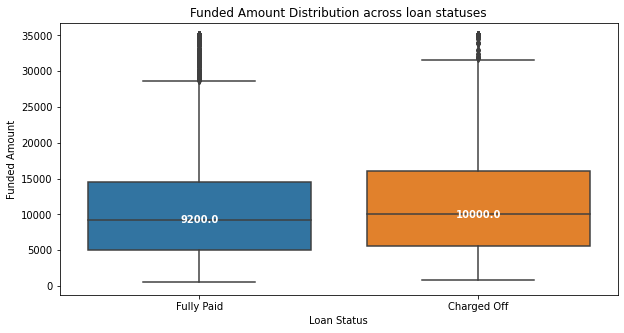

'Loan Applicants with higher Funded Amount tend to default more than that of lower amounts'

In [69]:
# Segmented Univariate analysis using loan_amnt
box_plot = sns.boxplot(x='loan_status',y='funded_amnt',data=df)
display_median_box_plot(box_plot)
plt.ylabel('Funded Amount')
plt.xlabel('Loan Status')
plt.title('Funded Amount Distribution across loan statuses')
plt.show()
"""Loan Applicants with higher Funded Amount tend to default more than that of lower amounts"""

In [ ]:
# Segmented Univariate analysis using term
df_grouped = df.groupby(['term','loan_status'])['loan_status'].count().unstack()
ax = df_grouped.apply(lambda x : round(x*100/x.sum()),axis=1).plot(kind='bar', stacked=True)
display_bar_height_in_percent(ax)
plt.xticks(rotation=0)
plt.ylabel('# Loan Applications')
plt.title('Loan Status Distribution across terms')
plt.show()
"""Loan Applicants with the term 60 months are more likely to default than that of 36 months"""

In [ ]:
# Segmented Univariate analysis using int_rate
fig, ax = plt.subplots()
ax.boxplot([df_co.int_rate,df_fp.int_rate])
plt.ylabel('Interest Rate')
plt.xlabel('Loan Status')
plt.title('Interest Rate Distribution across loan statuses')
plt.xticks([1,2],['Charged Off','Fully Paid'])
plt.show()

"""Loan Applicants who got loan for higher interest rates are more likely to default than that of lower interest rates"""

In [ ]:
# Segmented Univariate analysis using grade
df_grouped = df.groupby(['grade','loan_status'])['loan_status'].count().unstack()
df_grouped.apply(lambda x : round(x*100/x.sum()),axis=1).plot(kind='bar', stacked=True)
plt.xticks(rotation=0)
plt.ylabel('Loans Distribution (%)')
plt.xlabel('Grade')
plt.title('Loan Status Distribution across grades')
plt.show()

"""Loan Applicants with grades E,F,G are more likely to default than that of others. This correlates with interest rates analysis since E,F,G grades has higher interest rates"""

In [ ]:
# Segmented Univariate analysis using emp_length
df_grouped = df.groupby(['emp_length','loan_status'])['loan_status'].count().unstack()
df_grouped.apply(lambda x : round(x*100/x.sum()),axis=1).plot(kind='bar', stacked=True)
plt.xticks(rotation=90)
plt.ylabel('Loans Distribution (%)')
plt.xlabel('Employment Length')
plt.title('Loan Status Distribution (%) across Employment Length in years')
plt.show()

"""Loan Applicants with employment length of 10+years and NA tend to default more than others"""

In [ ]:
# Segmented Univariate analysis using home_ownership
df_grouped = df.groupby(['home_ownership','loan_status'])['loan_status'].count().unstack()
ax = df_grouped.apply(lambda x : round(x*100/x.sum()),axis=1).plot(kind='bar', stacked=True)
display_bar_height_in_percent(ax)
plt.xticks(rotation=90)
plt.ylabel('Loans Distribution (%)')
plt.xlabel('Home Ownership')
plt.title('Loan Status Distribution (%) across Home Ownership')
plt.show()


"""Applicants with Home Ownership OTHER tend to default more than others. Interesting fact to note that Home Ownership= None has no defaulters. """

In [ ]:
# Segmented Univariate analysis using annual_inc

# Remove the outliers to make IQR visible and comparable
df_co_90 = df_co[df_co.annual_inc <= df_co.annual_inc.quantile(0.90)]
df_fp_90 = df_fp[df_fp.annual_inc <= df_fp.annual_inc.quantile(0.90)]
fig, ax = plt.subplots()
ax.boxplot([df_co_90.annual_inc,df_fp_90.annual_inc])
plt.ylabel('Annual Income')
plt.xlabel('Loan Status')
plt.title('Annual Income Distribution across loan statuses')
plt.xticks([1,2],['Charged Off','Fully Paid'])
plt.show()

"""Loan Applicants who has lesser Annual Income are likely to default than that of higher annual income"""

In [ ]:
# Segmented Univariate analysis using Income Verification Status
df_grouped = df.groupby(['verification_status','loan_status'])['loan_status'].count().unstack()
ax = df_grouped.apply(lambda x : round(x*100/x.sum()),axis=1).plot(kind='bar', stacked=True)
display_bar_height_in_percent(ax)
plt.xticks(rotation=0)
plt.ylabel('Loans Distribution (%)')
plt.xlabel('Income Verification Status')
plt.title('Loan Status Distribution (%) across Income Verification Status')
plt.show()

"""Surprisingly, Loan Applications whose Income is verified defaults more than others by at least 2%. May be verification process needs to be revisited"""

In [ ]:
# Segmented Univariate analysis using purpose
df_grouped = df.groupby(['purpose','loan_status'])['loan_status'].count().unstack()
df_grouped.apply(lambda x : round(x*100/x.sum()),axis=1).plot(kind='bar', stacked=True)
plt.xticks(rotation=90)
plt.ylabel('Loans Distribution (%)')
plt.xlabel('Purpose')
plt.title('Loan Status Distribution (%) across Purpose')
plt.show()

"""Loan Applicants for the purpose of Small Business tend to default more than other purposes by a huge difference between 8 % - 17 %"""

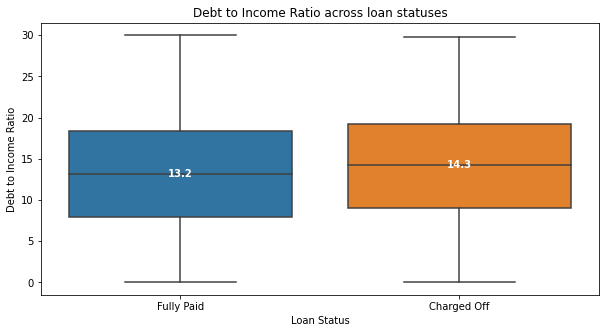

'It appears that loan applications with higher debt to income ratio likely to default. But this is not a strong indicator as the difference of dti between them in mean and 75th percentile is merely ~1 '

In [70]:
# Segmented Univariate analysis using dti
box_plot = sns.boxplot(x='loan_status',y='dti',data=df)
display_median_box_plot(box_plot)
plt.ylabel('Debt to Income Ratio')
plt.xlabel('Loan Status')
plt.title('Debt to Income Ratio across loan statuses')
plt.show()

"""It appears that loan applications with higher debt to income ratio likely to default. But this is not a strong indicator as the difference of dti between them in mean and 75th percentile is merely ~1 """

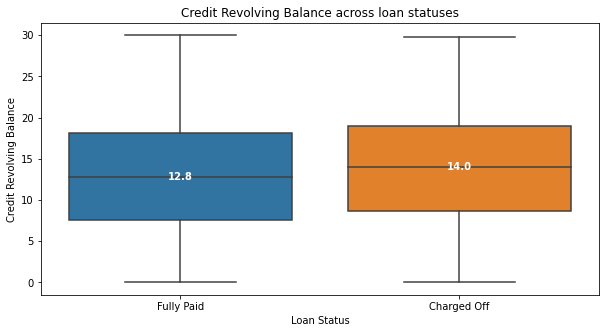

'Loan Applications with higher credit revolving balance are more likely to default than the others. The difference is not striking though'

In [71]:
# Segmented Univariate analysis using Credit Revolving Balance
# Remove the outliers to make IQR visible and comparable
box_plot = sns.boxplot(x='loan_status',y='dti',data=df[df.revol_bal <= df.revol_bal.quantile(0.90)])
display_median_box_plot(box_plot)
plt.ylabel('Credit Revolving Balance')
plt.xlabel('Loan Status')
plt.title('Credit Revolving Balance across loan statuses')
plt.show()

"""Loan Applications with higher credit revolving balance are more likely to default than the others. The difference is not striking though"""

In [ ]:
# Segmented Univariate analysis using Revolving Credit Utilization
fig, ax = plt.subplots()
ax.boxplot([df_co.revol_util,df_fp.revol_util])
plt.ylabel('Revolving Credit Utilization')
plt.xlabel('Loan Status')
plt.title('Revolving Credit Utilization across loan statuses')
plt.xticks([1,2],['Charged Off','Fully Paid'])
plt.show()

"""Loan Applications with higher revolving credit utilization tend to default the loan than others"""

# Bivariate Analysis

In [ ]:
# Bivariate Analysis: Loan Amount vs Funded Amount
ax = sns.scatterplot(x='loan_amnt',y='funded_amnt',data=df,hue='loan_status')
ax.set(xlabel='Loan Amount',ylabel='Funded Amount',title='Defaulting Rate by Loan Amount Vs Funded Amount')
plt.show()

"""There are very less defaulters when Funded Amount is same as the Loan Amount(linear relation)"""


In [ ]:
# Bivariate Analysis: Term vs Employment Length
df_grouped = df.groupby(['term','emp_length','loan_status'])['loan_status'].count().unstack()
df_grouped = df_grouped.apply(lambda x : round(x*100/x.sum()),axis=1)
df_grouped.drop(columns='Fully Paid',inplace=True)
df_unstacked = df_grouped.unstack()
df_unstacked.columns = df_unstacked.columns.droplevel()
ax = sns.heatmap(df_unstacked, annot=True,cmap=sns.cm.rocket_r,cbar_kws={'label': 'defaulters %'})
ax.set(xlabel='Employment Length',ylabel='Term',title='Defaulters % w.r.t Employment Length and Term')
plt.show()

"""Loan Applicants with employment length of 7 years and NA values tend to default more when the term of the loan is 60 months"""


In [ ]:
# Bivariate Analysis: Term vs Home Ownership
df_grouped = df.groupby(['term','home_ownership','loan_status'])['loan_status'].count().unstack()
df_grouped = df_grouped.apply(lambda x : round(x*100/x.sum()),axis=1)
df_grouped.drop(columns='Fully Paid',inplace=True)
df_unstacked = df_grouped.unstack()
df_unstacked.columns = df_unstacked.columns.droplevel()
ax = sns.heatmap(df_unstacked, annot=True,cmap=sns.cm.rocket_r,cbar_kws={'label': 'defaulters %'})
ax.set(xlabel='Home Ownership',ylabel='Term',title='Defaulters % w.r.t Home Ownership and Term')
plt.show()

"""Loan Applicants with term as 60 months and Home Ownership as OWN and RENT default more likely """


In [ ]:
# Bivariate Analysis: Term vs Verification Status
df_grouped = df.groupby(['term','verification_status','loan_status'])['loan_status'].count().unstack()
df_grouped = df_grouped.apply(lambda x : round(x*100/x.sum()),axis=1)
df_grouped.drop(columns='Fully Paid',inplace=True)
df_unstacked = df_grouped.unstack()
df_unstacked.columns = df_unstacked.columns.droplevel()
ax = sns.heatmap(df_unstacked, annot=True,cmap=sns.cm.rocket_r,cbar_kws={'label': 'defaulters %'})
ax.set(xlabel='Income Verification Status',ylabel='Term',title='Defaulters % w.r.t Income Verification Status and Term')
plt.show()

"""Loan Applications with term as 60 months and their income verified and source verified tend to default more likely than others"""

In [ ]:
# Bivariate Analysis: Term vs Purpose
df_grouped = df.groupby(['term','purpose','loan_status'])['loan_status'].count().unstack()
df_grouped = df_grouped.apply(lambda x : round(x*100/x.sum()),axis=1)
df_grouped.drop(columns='Fully Paid',inplace=True)
df_unstacked = df_grouped.unstack()
df_unstacked.columns = df_unstacked.columns.droplevel()
ax = sns.heatmap(df_unstacked, annot=True,cmap=sns.cm.rocket_r,cbar_kws={'label': 'defaulters %'})
ax.set(xlabel='Purpose',ylabel='Term',title='Defaulters % w.r.t Purpose and Term')
plt.show()

"""Loan Applicants with term as 60 months are more likely to default when the purpose is educational and small business"""

In [ ]:
# Bivariate Analysis: Term vs revol_bal
df_filtered = df[df.revol_bal <= df.revol_bal.quantile(0.90)] # Remove Outliers to compare the data
ax = sns.catplot(x='term',y='revol_bal',data=df_filtered,hue='loan_status',kind='box')
ax.set(xlabel='Term',ylabel='Total Credit Revolving Balance',title='Loan Status distribution w.r.t Total Credit Revolving Balance and Term')
plt.show()

"""Loan Applicants with higher Total Credit Revolving Balance tend to default likely when the term is 60 months"""

In [ ]:
# Bivariate Analysis: Emp Length vs Home Ownership
df_grouped = df.groupby(['emp_length','home_ownership','loan_status'])['loan_status'].count().unstack()
df_grouped = df_grouped.apply(lambda x : round(x*100/x.sum()),axis=1)
df_grouped.drop(columns='Fully Paid',inplace=True)
df_unstacked = df_grouped.unstack()
df_unstacked.columns = df_unstacked.columns.droplevel()
ax = sns.heatmap(df_unstacked, annot=True,cmap=sns.cm.rocket_r,cbar_kws={'label': 'defaulters %'})
ax.set(xlabel='Home Ownership',ylabel='Employment Length',title='Defaulters % w.r.t Home Ownership and Employment Length')
plt.show()


"""Loan Applicants with OTHER home ownership tend to default more when their employment length is 7 years or 3 years"""

In [ ]:
# Bivariate Analysis: Emp Length vs Purpose
df_grouped = df.groupby(['emp_length','purpose','loan_status'])['loan_status'].count().unstack()
df_grouped = df_grouped.apply(lambda x : round(x*100/x.sum()),axis=1)
df_grouped.drop(columns='Fully Paid',inplace=True)
df_unstacked = df_grouped.unstack()
df_unstacked.columns = df_unstacked.columns.droplevel()
ax = sns.heatmap(df_unstacked, annot=True,cmap=sns.cm.rocket_r,cbar_kws={'label': 'defaulters %'})
ax.set(xlabel='Purpose',ylabel='Employment Length',title='Defaulters % w.r.t Purpose and Employment Length')
plt.show()

"""Loan Applicants for purpose as renewable energy tend to likely default when their employment length is 4 years or 8 years. Also, Loan Applicants with no employment length specified tend to default more for educational purpose"""


In [ ]:
# Bivariate Analysis: Home ownership vs Purpose
df_grouped = df.groupby(['home_ownership','purpose','loan_status'])['loan_status'].count().unstack()
df_grouped = df_grouped.apply(lambda x : round(x*100/x.sum()),axis=1)
df_grouped.drop(columns='Fully Paid',inplace=True)
df_unstacked = df_grouped.unstack()
df_unstacked.columns = df_unstacked.columns.droplevel()
ax = sns.heatmap(df_unstacked, annot=True,cmap=sns.cm.rocket_r,cbar_kws={'label': 'defaulters %'})
ax.set(xlabel='Purpose',ylabel='Home Ownership',title='Defaulters % w.r.t Purpose and Home Ownership')
plt.show()

"""Loan Applicants for the purpose of small business tend to default more across RENT, OWN and OTHER home ownerships. Also, Car - OTHER combination seem to default likely"""